# Using public data on NIRD using s3 and saving results in private s3 object storage

<div class="alert alert-success alert-info">
    <b>How to discover (spatial and temporal search and subsetting) Obs-CERES-EBAF model output prepared for obs4MIPs OBSERVATIONS dataset</b>
    <ul>
    <li>We show how to access s3 anonymous data in netCDF, make a geographical area selection and store into zarr on s3 private object storage</li>
        <li>We do not address dask (chunking optimization, etc.)</li>
    </ul>
</div>

In [1]:
import s3fs
import xarray as xr

## Connect to bucket (anonymous login for public data only)

In [2]:
fs = s3fs.S3FileSystem(anon=True,
      client_kwargs={
         'endpoint_url': 'https://climate.uiogeo-apps.sigma2.no/'
      })

### List bucket content

In [3]:
fs.ls('ESGF')

['ESGF/#README#',
 'ESGF/ALL_FILES_AND_DIRS_BELOW_HERE_SHALL_HAVE_GID_ns9252k_AND_WRITE_PERMS',
 'ESGF/CMIP6',
 'ESGF/cmip5',
 'ESGF/files_with_permission_problem_8Sept2021.txt',
 'ESGF/ns9252k_esgf_md5_betzy_sorted.txt',
 'ESGF/ns9252k_esgf_md5_sorted.txt',
 'ESGF/obs4MIPs',
 'ESGF/simass_SImon_EC-Earth3-CC_piControl_r1i1p1f1_gn_187201-187212.nc']

In [4]:
fs.ls('ESGF/obs4MIPs/CERES-EBAF/')

['ESGF/obs4MIPs/CERES-EBAF/rlut_CERES-EBAF_L3B_Ed2-8_200003-201404.nc',
 'ESGF/obs4MIPs/CERES-EBAF/rsut_CERES-EBAF_L3B_Ed2-8_200003-201404.nc']

## Access data files 
- if netCDF format is used, data access can be slow)
- you should try to use cloud zarr format 

In [5]:
s3path = 's3://ESGF/obs4MIPs/CERES-EBAF/*.nc'

In [6]:
remote_files = fs.glob(s3path)

In [7]:
remote_files

['ESGF/obs4MIPs/CERES-EBAF/rlut_CERES-EBAF_L3B_Ed2-8_200003-201404.nc',
 'ESGF/obs4MIPs/CERES-EBAF/rsut_CERES-EBAF_L3B_Ed2-8_200003-201404.nc']

In [8]:
# Iterate through remote_files to create a fileset
fileset = [fs.open(file) for file in remote_files]

# This works
dset = xr.open_mfdataset(fileset, combine='by_coords')

In [9]:
dset

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 180, lon: 360, time: 170)
Coordinates:
  * time       (time) datetime64[ns] 2000-03-16T12:00:00 ... 2014-04-16
  * lat        (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(170, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(180, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    rlut       (time, lat, lon) float32 dask.array<chunksize=(170, 180, 360), meta=np.ndarray>
    rsut       (time, lat, lon) float32 dask.array<chunksize=(170, 180, 360), meta=np.ndarray>
Attributes: (12/27)
    institution:         NASA Langley Research Center, Hampton, Va, USA
    institute_id:        NASA-LaRC
    experiment_id:       obs
    source:              CERES retrievals
    model_id:            Obs-CERES-EBAF
    contact:             Norman Loeb, norman.g.loeb@nasa.gov
    ...                  ...
    Conventions:         CF-1.4
    project_id:          obs4MIPs
    table_id:            Table Amon_obs (10 March 2011) c2e3700dd6af44ea84f7a...
    title:               Obs-CERES-EBAF model output prepared for obs4MIPs OB...
    modeling_realm:      atmos
    cmor_version:        2.8.3

## Shift longitude from 0 to 360 to -180 to 180 for convenience (when subsetting)

In [10]:
dset = dset.assign_coords(lon=(((dset.lon + 180) % 360) - 180)).sortby('lon')

## Plot a single time

In [11]:
!pip install cmaps

In [12]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cmaps

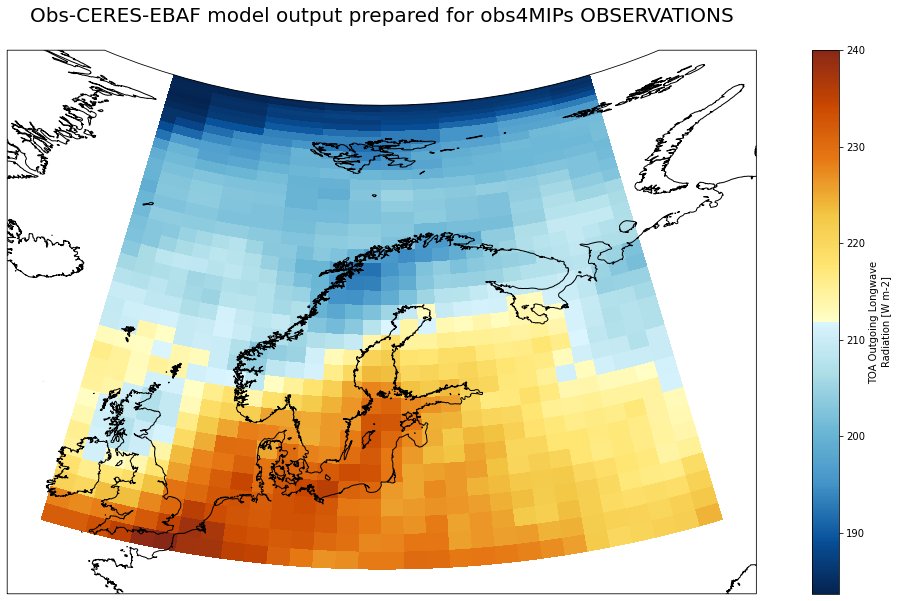

In [13]:
fig=plt.figure(figsize=(20,10))

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=20.0, central_latitude=40.0))
ax.coastlines(resolution='10m')

# custom colormap

lcmap = cmaps.BlueYellowRed

# We need to project our data to the new Mercator projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
# we only plot values greather than 0
dset['rlut'].sel(time='2011-10-16').sel(lat=slice(50,90), lon=slice(-10,50)).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=lcmap)  
ax.set_title('Obs-CERES-EBAF model output prepared for obs4MIPs OBSERVATIONS\n ', fontsize=20)
plt.savefig('Obs-CERES-EBAF_rlut_2011-10-16.png')

## Save results in zarr on NIRD for further analysis
- your credentials are in `$HOME/.aws/credentials` 
- check with your instructor to get the secret access key (replace XXX by the right key)

```
[default]
aws_access_key_id=forces2021-work
aws_secret_access_key=XXXXXXXXXXXX
aws_endpoint_url=https://forces2021.uiogeo-apps.sigma2.no/
```

In [14]:
import fsspec

### Set the path to your group's location (ask your instructor)

In [15]:
target = fsspec.get_mapper("s3://work/obs4MIPs_CERES-EBAFObs_rlut_rsut.zarr", 
                  client_kwargs={
                  'endpoint_url': 'https://forces2021.uiogeo-apps.sigma2.no/'
                  }
            )

In [16]:
dset.sel(lat=slice(50,90), lon=slice(-10,50)).to_zarr(store=target, mode="w", consolidated=True, compute=True)

## Check what you have stored in s3

- we use https://forces2021.uiogeo-apps.sigma2.no/ as an endpoint
- we need to authenticate to access data (anon=False)

### Initilize the S3 file system

In [17]:
fsg = s3fs.S3FileSystem(anon=False,
      client_kwargs={
         'endpoint_url': 'https://forces2021.uiogeo-apps.sigma2.no/'
      })

In [18]:
fsg.ls('work')

['work/obs4MIPs_CERES-EBAFObs_rlut_rsut.zarr']

### Set path to s3 data

In [19]:
s3_path = 's3://work/obs4MIPs_CERES-EBAFObs_rlut_rsut.zarr'

### Initialize the S3 filesystem 

In [20]:
store = s3fs.S3Map(root=s3_path, s3=fsg, check=False)

In [21]:
ds = xr.open_zarr(store=store, consolidated=True)

In [22]:
ds

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 40, lon: 60, time: 170)
Coordinates:
  * lat        (lat) float64 50.5 51.5 52.5 53.5 54.5 ... 86.5 87.5 88.5 89.5
  * lon        (lon) float64 -9.5 -8.5 -7.5 -6.5 -5.5 ... 46.5 47.5 48.5 49.5
  * time       (time) datetime64[ns] 2000-03-16T12:00:00 ... 2014-04-16
Dimensions without coordinates: bnds
Data variables:
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(40, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
    rlut       (time, lat, lon) float32 dask.array<chunksize=(170, 40, 60), meta=np.ndarray>
    rsut       (time, lat, lon) float32 dask.array<chunksize=(170, 40, 60), meta=np.ndarray>
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(170, 2), meta=np.ndarray>
Attributes: (12/27)
    Conventions:         CF-1.4
    cmor_version:        2.8.3
    contact:             Norman Loeb, norman.g.loeb@nasa.gov
    creation_date:       2014-07-29T14:04:11Z
    data_structure:      grid
    experiment_id:       obs
    ...                  ...
    source:              CERES retrievals
    source_id:           CERES-EBAF
    source_type:         satellite_retrieval
    table_id:            Table Amon_obs (10 March 2011) c2e3700dd6af44ea84f7a...
    title:               Obs-CERES-EBAF model output prepared for obs4MIPs OB...
    tracking_id:         5da4db80-31cb-4340-b5e1-0fbacaee873a

### Plot TOA outgoing shortwave Radiation
- Note that there is no need to select an area because the s3 dataset only cover the area of interest (selected when saving dataset in s3 storage)

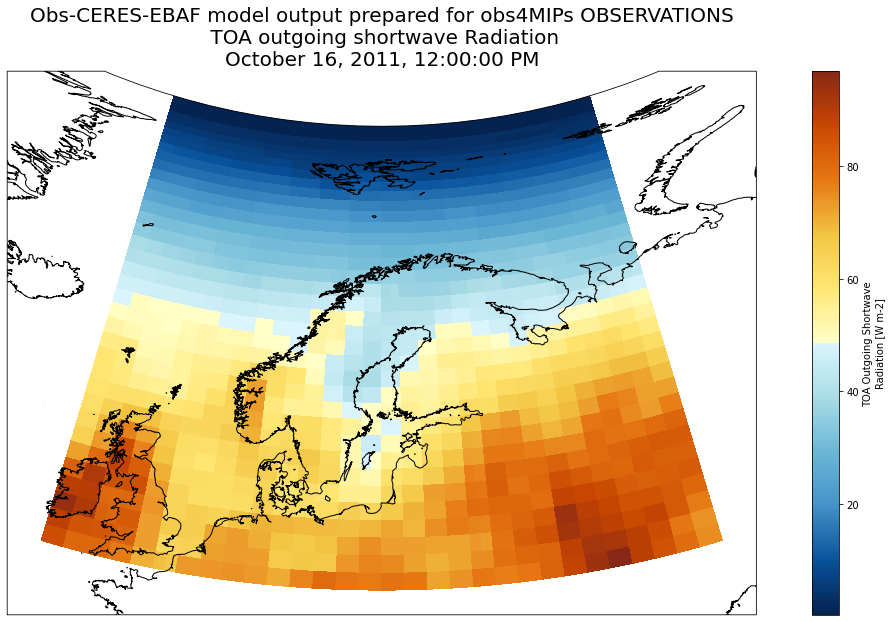

In [23]:
fig=plt.figure(figsize=(20,10))

# We're using cartopy and are plotting in Orthographic projection 
# (see documentation on cartopy)
ax = plt.subplot(1, 1, 1, projection=ccrs.AlbersEqualArea(central_longitude=20.0, central_latitude=40.0))
ax.coastlines(resolution='10m')

# custom colormap

lcmap = cmaps.BlueYellowRed

# We need to project our data to the new Mercator projection and for this we use `transform`.
# we set the original data projection in transform (here PlateCarree)
# we only plot values greather than 0
ds['rsut'].sel(time='2011-10-16').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=lcmap)  
ax.set_title('Obs-CERES-EBAF model output prepared for obs4MIPs OBSERVATIONS\n TOA outgoing shortwave Radiation\n' + str(ds.time.sel(time='2011-10-16').dt.strftime("%B %d, %Y, %r").values[0]), fontsize=20)
plt.savefig('Obs-CERES-EBAF_rsut_2011-10-16.png')